In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize

### Reading monthly returns

Monthly figures, we have end-of-month data, not always prefectly aligned to the end of month

In [2]:
USD_monthly_returns = pd.read_csv('data/US_value_weighted_returns.csv', parse_dates=['date'], index_col='date')

japan       = pd.read_csv("data/JAPAN.csv",       parse_dates=["date"], index_col="date")[["mportret"]]
australia   = pd.read_csv("data/AUSTRALIA.csv",   parse_dates=["date"], index_col="date")[["mportret"]]
germany     = pd.read_csv("data/GERMANY.csv",     parse_dates=["date"], index_col="date")[["mportret"]]
france      = pd.read_csv("data/FRANCE.csv",      parse_dates=["date"], index_col="date")[["mportret"]]
switzerland = pd.read_csv("data/SWITZERLAND.csv", parse_dates=["date"], index_col="date")[["mportret"]]
unitedkingdom = pd.read_csv("data/UNITEDKINGDOM.csv", parse_dates=["date"], index_col="date")[["mportret"]]

switzerland.head()

,mportret
date,
2000-01-31,-0.072023
2000-02-29,-0.001949
2000-03-31,0.081995
2000-04-28,0.002559
2000-05-31,0.042735


### Reading exchange rates

Monthly figures, we have beginning-of-month data

In [3]:
def load_fx_series(filepath: str, invert: bool = False) -> pd.Series:
    """Load FX series and convert to currency → USD if needed."""
    df = pd.read_csv(filepath, parse_dates=['observation_date'], index_col='observation_date')
    series = df.iloc[:, 0]
    return 1 / series if invert else series

# Load FX rates (all to USD)
fx_jpy = load_fx_series('data/EXJPUS.csv', invert=True)   # JPY → USD
fx_chf = load_fx_series('data/EXSZUS.csv', invert=True)   # CHF → USD
fx_aud = load_fx_series('data/EXUSAL.csv')                # AUD → USD
fx_eur = load_fx_series('data/EXUSEU.csv')                # EUR → USD
fx_gbp = load_fx_series('data/EXUSUK.csv')                # GBP → USD

# Preview one of the results
fx_chf.tail()
fx_jpy.tail()
fx_gbp.tail()

observation_date
2024-08-01    1.2945
2024-09-01    1.3219
2024-10-01    1.3043
2024-11-01    1.2738
2024-12-01    1.2647
Name: EXUSUK, dtype: float64

FX are beginning of month, returns are end of months --> we will shift back FX to previous month, we will also push returns to exactly end of month.

In [4]:
def align_returns_to_month_end(ret_df: pd.DataFrame) -> pd.DataFrame:
    """
    Take a returns DataFrame (or Series) whose index is a date somewhere
    in a month, and “snap” that date to the LAST calendar day of the same month.

    E.g. 2000-04-28 → 2000-04-30; 2000-02-29 → 2000-02-29; 2000-06-30 → 2000-06-30.
    """
    df = ret_df.copy()
    df.index = df.index.to_period("M").to_timestamp("M")
    return df

def align_fx_to_previous_month_end(fx_obj) -> pd.DataFrame:
    """
    Take an FX Series or single‐column DataFrame whose index is ANY date 
    in a month (e.g. 2000-05-01 or 2000-05-15), and move that entire index 
    to the *previous* month’s last calendar day.

    - If fx_obj.index is a DatetimeIndex:  (ix.to_period("M") - 1).to_timestamp("M")
    - If fx_obj.index is already a PeriodIndex:        (ix - 1).to_timestamp("M")
    """
    # Copy it so we do not mutate the original
    df = fx_obj.copy()
    ix = df.index

    if isinstance(ix, pd.DatetimeIndex):
        df.index = (ix.to_period("M") - 1).to_timestamp("M")

    elif isinstance(ix, pd.PeriodIndex):
        df.index = (ix - 1).to_timestamp("M")

    else:
        dt = pd.to_datetime(ix)
        df.index = (dt.to_period("M") - 1).to_timestamp("M")

    return df

In [5]:
def merge_one_country(returns_df: pd.DataFrame, fx_obj) -> pd.DataFrame:
    """
    1) Snap returns_df index to the SAME month‐end.
    2) Snap fx_obj (Series or DataFrame) index to the PREVIOUS month‐end.
    3) Rename columns to 'return' and 'fx'.
    4) Merge on that common index (inner join).
    """
    # --- Step 1: Align returns to month‐end (same month).
    ret_aligned = align_returns_to_month_end(returns_df)
    ret_aligned = ret_aligned.rename(columns={ret_aligned.columns[0]: "return"})
    
    # --- Step 2: Align FX backward to previous month‐end.
    fx_aligned = align_fx_to_previous_month_end(fx_obj)
    
    # If fx_aligned is a Series, convert it to a DataFrame named "fx".
    if isinstance(fx_aligned, pd.Series):
        fx_aligned = fx_aligned.to_frame(name="fx")
    else:
        # Otherwise it's already a DataFrame with one column—rename that column to "fx"
        fx_aligned = fx_aligned.rename(columns={fx_aligned.columns[0]: "fx"})
    
    # --- Step 3: Inner‐merge on the aligned index.
    merged = pd.merge(
        ret_aligned,
        fx_aligned,
        left_index=True,
        right_index=True,
        how="inner"
    )
    return merged



In [6]:
returns_dict = {
    "japan":       japan,
    "australia":   australia,
    "germany":     germany,
    "france":      france,
    "switzerland": switzerland,
    "unitedkingdom": unitedkingdom
}

fx_dict = {
    "japan":         fx_jpy,   
    "switzerland":   fx_chf,   
    "australia":     fx_aud,   
    "germany":       fx_eur,   
    "france":        fx_eur,   
    "unitedkingdom": fx_gbp    
}

merged_data = {}

for country in returns_dict.keys():
    # grab raw returns DataFrame + raw FX (Series or DF) for this country
    raw_ret = returns_dict[country]
    raw_fx  = fx_dict[country]

    merged_df = merge_one_country(raw_ret, raw_fx)
    merged_data[country] = merged_df

In [7]:
merged_data["japan"].head()

,return,fx
2000-01-31,-0.005118,0.009142
2000-02-29,0.013960,0.009407
2000-03-31,-0.006549,0.009467
2000-04-30,-0.036598,0.009232
2000-05-31,-0.074170,0.009423


# 3.a. Returns of each index in USD

In [8]:
def compute_usd_returns(merged_data: dict) -> dict:
    """
    Given:
      - merged_data: a dict mapping country_name → DataFrame
        where each DataFrame has exactly two columns:
           'return' (local index return, aligned to month‐end)
           'fx'     (USD exchange rate, aligned to previous month‐end)
    
    This function:
      1. Copies each country’s DataFrame.
      2. Computes fx_return = fx / fx.shift(1) - 1
      3. Computes usd_return = (1 + return) * (1 + fx_return) - 1
      4. Drops any rows with NaNs (from the shift).
      5. Returns a new dict (same keys) whose DataFrames now contain:
         ['return', 'fx', 'fx_return', 'usd_return'].
    """
    processed_data = {}
    
    for country, df_original in merged_data.items():
        # 1) Make a copy so we don’t overwrite the original
        df = df_original.copy()
        
        # 2) Compute the monthly FX return
        #    (percent change in the USD/FX rate from previous row → current row)
        df['fx_return'] = df['fx'] / df['fx'].shift(1) - 1
        
        # 3) Compute the USD‐denominated total return:
        #    (1 + local_index_return) * (1 + fx_return) − 1
        df['usd_return'] = (1 + df['return']) * (1 + df['fx_return']) - 1
        
        # 4) Drop any rows with NaNs (the first row will become NaN in fx_return)
        df.dropna(inplace=True)
        
        # 5) Store the result under the same country key
        processed_data[country] = df
    
    return processed_data

In [9]:
processed_data = compute_usd_returns(merged_data)
processed_data["japan"].head()

,return,fx,fx_return,usd_return
2000-02-29,0.013960,0.009407,0.028983,0.043347
2000-03-31,-0.006549,0.009467,0.006442,-0.000149
2000-04-30,-0.036598,0.009232,-0.024866,-0.060554
2000-05-31,-0.074170,0.009423,0.020683,-0.055021
2000-06-30,0.047394,0.009241,-0.019277,0.027203


# 3.b. Currency-hedged index return

Initializing correct data, start with interbank rates

In [10]:
#    Read each 3-month interbank CSV, parse the "observation_date" column as DatetimeIndex,
#    select only the rate column, and rename it to the correct ISO code.

aus_ib = pd.read_csv(
    "data/AUSTRALIA_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
aus_ib = aus_ib.iloc[:, [0]].rename(columns={aus_ib.columns[0]: "AUD"})
aus_ib["AUD"] = aus_ib["AUD"] / 100


eur_ib = pd.read_csv(
    "data/EUROPE_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
eur_ib = eur_ib.iloc[:, [0]].rename(columns={eur_ib.columns[0]: "EUR"})
eur_ib["EUR"] = eur_ib["EUR"] / 100


gbp_ib = pd.read_csv(
    "data/GREATBRITAIN_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
gbp_ib = gbp_ib.iloc[:, [0]].rename(columns={gbp_ib.columns[0]: "GBP"})
gbp_ib["GBP"] = gbp_ib["GBP"] / 100


jpy_ib = pd.read_csv(
    "data/JAPAN_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
jpy_ib = jpy_ib.iloc[:, [0]].rename(columns={jpy_ib.columns[0]: "JPY"})
jpy_ib["JPY"] = jpy_ib["JPY"] / 100


chf_ib = pd.read_csv(
    "data/SWITZERLAND_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
chf_ib = chf_ib.iloc[:, [0]].rename(columns={chf_ib.columns[0]: "CHF"})
chf_ib["CHF"] = chf_ib["CHF"] / 100

usd_ib = pd.read_csv(
    "data/USA_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
usd_ib = usd_ib.iloc[:, [0]].rename(columns={usd_ib.columns[0]: "USD"})
usd_ib["USD"] = usd_ib["USD"] / 100

# Combine all six DataFrames side-by-side (inner join on the common dates)
ibexr = pd.concat(
    [usd_ib, eur_ib, jpy_ib, gbp_ib, chf_ib, aus_ib],
    axis=1,
    join="inner"
)

# Ensure the index is sorted and is exactly at month-end
ibexr.index = pd.to_datetime(ibexr.index)
ibexr = ibexr.sort_index()

ibexr = ibexr.resample("M").last().dropna(how="all")

print(ibexr.head())


                     USD       EUR     JPY       GBP       CHF     AUD
observation_date                                                      
2002-04-30        0.0187  0.034069  0.0010  0.041732  0.014606  0.0459
2002-05-31        0.0182  0.034671  0.0008  0.041537  0.011635  0.0484
2002-06-30        0.0181  0.034640  0.0009  0.041776  0.011496  0.0507
2002-07-31        0.0179  0.034100  0.0009  0.040605  0.010031  0.0498
2002-08-31        0.0173  0.033519  0.0007  0.039865  0.006683  0.0496


/var/folders/8v/10cr8tb10sj9jl40zffsd8900000gn/T/ipykernel_30024/2980223554.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ibexr = ibexr.resample("M").last().dropna(how="all")


In [11]:
iso_map = {
    "japan":         "JPN",
    "australia":     "AUS",
    "germany":       "DEU",
    "france":        "FRA",
    "switzerland":   "CHE",
    "unitedkingdom": "GBR"
}

idx_returns = pd.DataFrame({
    iso_map[country]: df["usd_return"]
    for country, df in processed_data.items()
})
idx_returns.index = pd.to_datetime(idx_returns.index)
idx_returns = idx_returns.sort_index()

cexr = pd.DataFrame({
    "JPY": processed_data["japan"]["fx"],
    "CHF": processed_data["switzerland"]["fx"],
    "AUD": processed_data["australia"]["fx"],
    "EUR": processed_data["germany"]["fx"],
    "GBP": processed_data["unitedkingdom"]["fx"]
})
cexr.index = pd.to_datetime(cexr.index)
cexr = cexr.sort_index()

In [15]:
# First, let's create a mapping between ISO codes and currency codes
iso_to_currency = {
    "AUS": "AUD",
    "CHE": "CHF", 
    "DEU": "EUR",
    "FRA": "EUR",
    "GBR": "GBP",
    "JPN": "JPY"
}

# Load USD T-bill rates (these are the r^US in the formula)
# Load USD T-bill rates (these are the r^US in the formula)
tbill = pd.read_csv('data/tbill.csv', sep=';', parse_dates=['mcaldt'], index_col='mcaldt')
tbill = tbill.rename(columns={'tmytm': 'USD'})
tbill['USD'] = tbill['USD'] / 100  # Convert percentage to decimal
tbill.index = pd.to_datetime(tbill.index)
tbill.index = tbill.index.to_period('M').to_timestamp('M')  # Convert to month-end

# Function to compute excess returns (X_t)
def compute_excess_returns(cexr, ibexr, tbill):
    """
    Compute excess returns X_t for each currency according to formula (1):
    X_{t+1} = (S_{t+1}/S_t) * (1 + r^foreign) - (1 + r^US)
    
    Where:
    - S_t is spot rate (USD per foreign currency)
    - r^foreign is foreign 3-month rate (monthly)
    - r^US is US 3-month rate (monthly)
    """
    
    # Convert annual rates to monthly rates
    monthly_factor = 3/12  # Since these are 3-month rates
    
    # Initialize DataFrame for excess returns
    excess_returns = pd.DataFrame(index=cexr.index, columns=cexr.columns)
    
    # Get common date range
    common_dates = cexr.index.intersection(ibexr.index).intersection(tbill.index)
    
    for currency in cexr.columns:
        # Get the spot rate series
        spot = cexr[currency]
        
        # Get foreign interest rate (already in decimals)
        if currency in ibexr.columns:
            r_foreign = ibexr[currency] * monthly_factor
        else:
            print(f"Warning: No interbank rate found for {currency}")
            continue
            
        # Get USD interest rate
        r_usd = tbill['USD'] * monthly_factor
        
        # Align all series to common dates
        spot_aligned = spot.reindex(common_dates)
        r_foreign_aligned = r_foreign.reindex(common_dates)
        r_usd_aligned = r_usd.reindex(common_dates)
        
        # Compute spot rate returns (S_{t+1}/S_t)
        spot_returns = spot_aligned / spot_aligned.shift(1)
        
        # Compute excess returns: (S_{t+1}/S_t) * (1 + r^foreign) - (1 + r^US)
        excess_returns[currency] = (spot_returns * (1 + r_foreign_aligned.shift(1)) - 
                                    (1 + r_usd_aligned.shift(1)))
        
    # Drop the first row (NaN from shift)
    excess_returns = excess_returns.dropna(how='all')
    
    return excess_returns

# Compute excess returns
excess_returns = compute_excess_returns(cexr, ibexr, tbill)

# Now compute currency-hedged returns
def compute_hedged_returns(idx_returns, excess_returns, iso_to_currency):
    """
    Compute currency-hedged returns: R_hedged = R_unhedged - X
    """
    
    # Initialize DataFrame for hedged returns
    hedged_returns = pd.DataFrame(index=idx_returns.index, columns=idx_returns.columns)
    
    # Get common dates
    common_dates = idx_returns.index.intersection(excess_returns.index)
    
    for iso_code in idx_returns.columns:
        # Get the corresponding currency
        currency = iso_to_currency[iso_code]
        
        if currency not in excess_returns.columns:
            print(f"Warning: No excess return data for {currency}")
            continue
            
        # Align both series to common dates
        unhedged = idx_returns[iso_code].reindex(common_dates)
        excess = excess_returns[currency].reindex(common_dates)
        
        # Compute hedged return
        hedged_returns[iso_code] = unhedged - excess
    
    # Keep only rows with at least one non-NaN value
    hedged_returns = hedged_returns.dropna(how='all')
    
    return hedged_returns

# Compute currency-hedged returns
hedged_returns = compute_hedged_returns(idx_returns, excess_returns, iso_to_currency)

# Display results
print("Currency-Hedged Returns (first 5 rows):")
print(hedged_returns.head())
print(f"\nShape: {hedged_returns.shape}")
print(f"Date range: {hedged_returns.index[0]} to {hedged_returns.index[-1]}")

# Verify the calculation with an example
print("\n\nVerification for France (EUR) - May 2002:")
idx = hedged_returns.index.get_loc('2002-05-31')
if idx > 0:
    print(f"Unhedged return: {idx_returns.loc['2002-05-31', 'FRA']:.6f}")
    print(f"EUR excess return: {excess_returns.loc['2002-05-31', 'EUR']:.6f}")
    print(f"Hedged return: {hedged_returns.loc['2002-05-31', 'FRA']:.6f}")
    print(f"Check: {idx_returns.loc['2002-05-31', 'FRA']:.6f} - {excess_returns.loc['2002-05-31', 'EUR']:.6f} = {idx_returns.loc['2002-05-31', 'FRA'] - excess_returns.loc['2002-05-31', 'EUR']:.6f}")

Currency-Hedged Returns (first 5 rows):
                 JPN       AUS       DEU       FRA       CHE       GBR
2002-05-31  0.041013 -0.007688 -0.031297 -0.033709  0.003671 -0.017892
2002-06-30 -0.083580 -0.033648 -0.076152 -0.088750 -0.084286 -0.093244
2002-07-31 -0.053246 -0.045184 -0.111565 -0.106815 -0.128784 -0.094542
2002-08-31 -0.019962  0.008043 -0.007201 -0.008930  0.006831 -0.003120
2002-09-30 -0.016746 -0.048155 -0.209275 -0.152941 -0.086987 -0.120339

Shape: (271, 6)
Date range: 2002-05-31 00:00:00 to 2024-11-30 00:00:00


Verification for France (EUR) - May 2002:


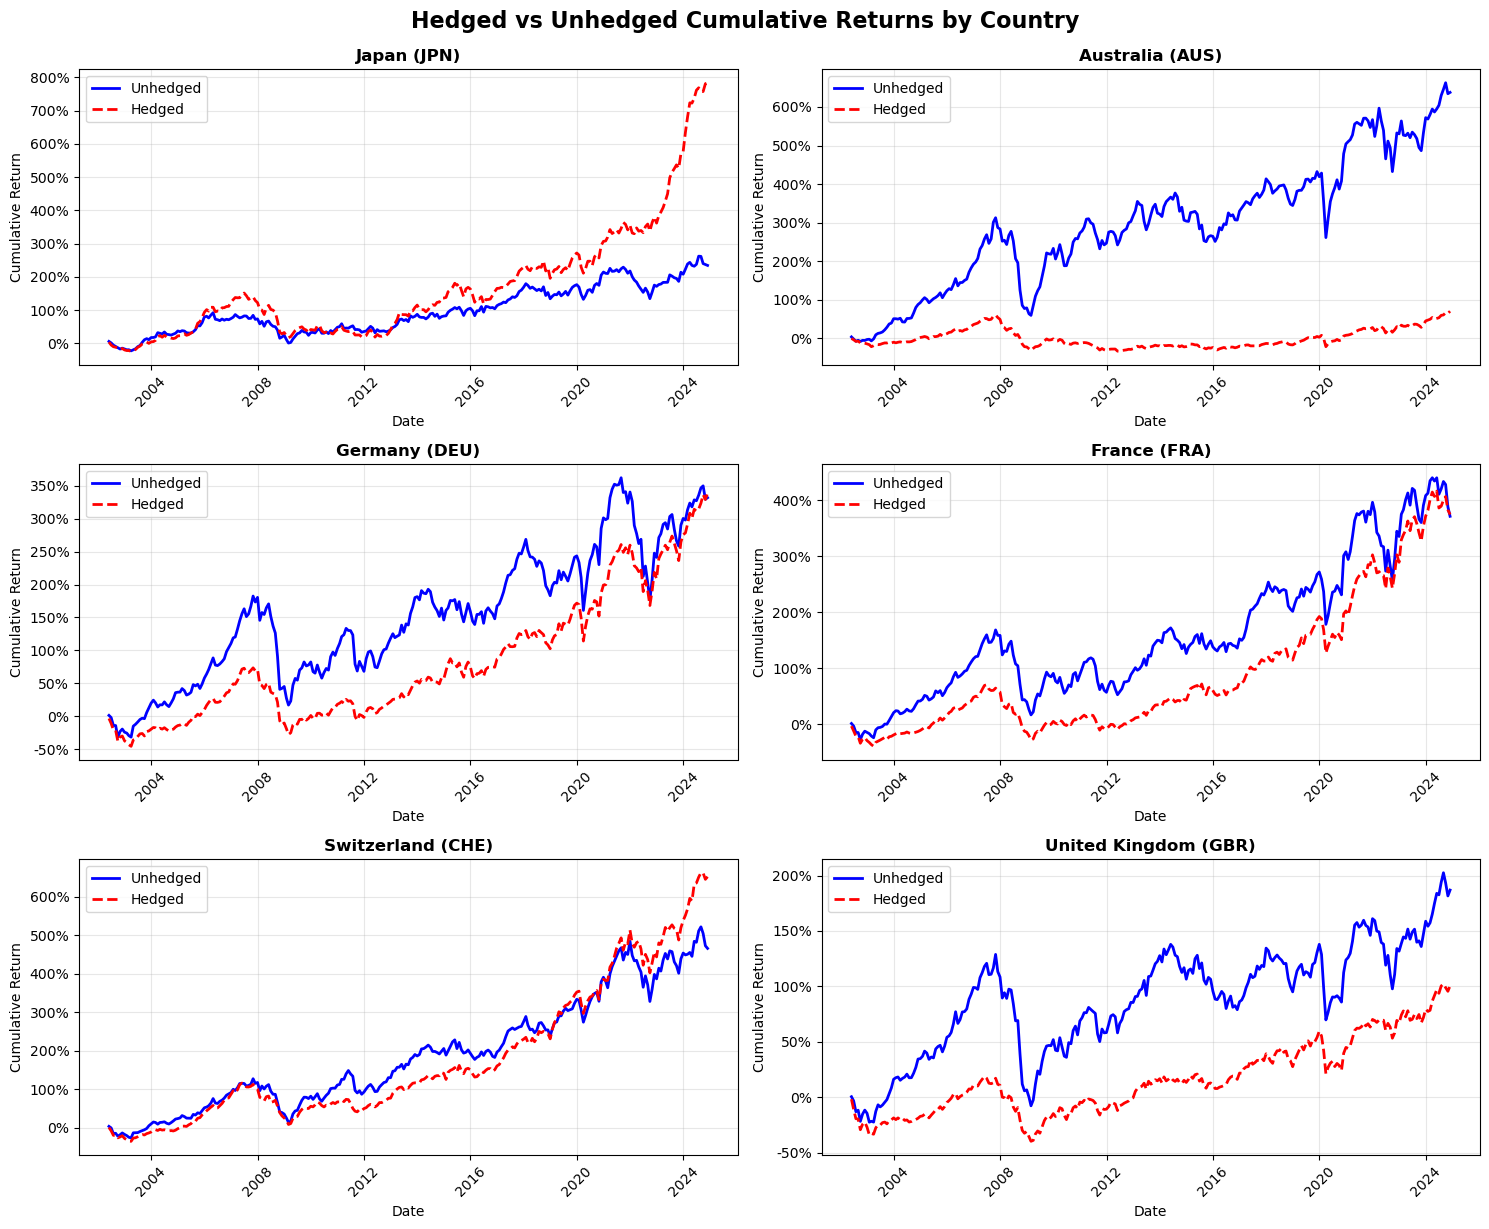

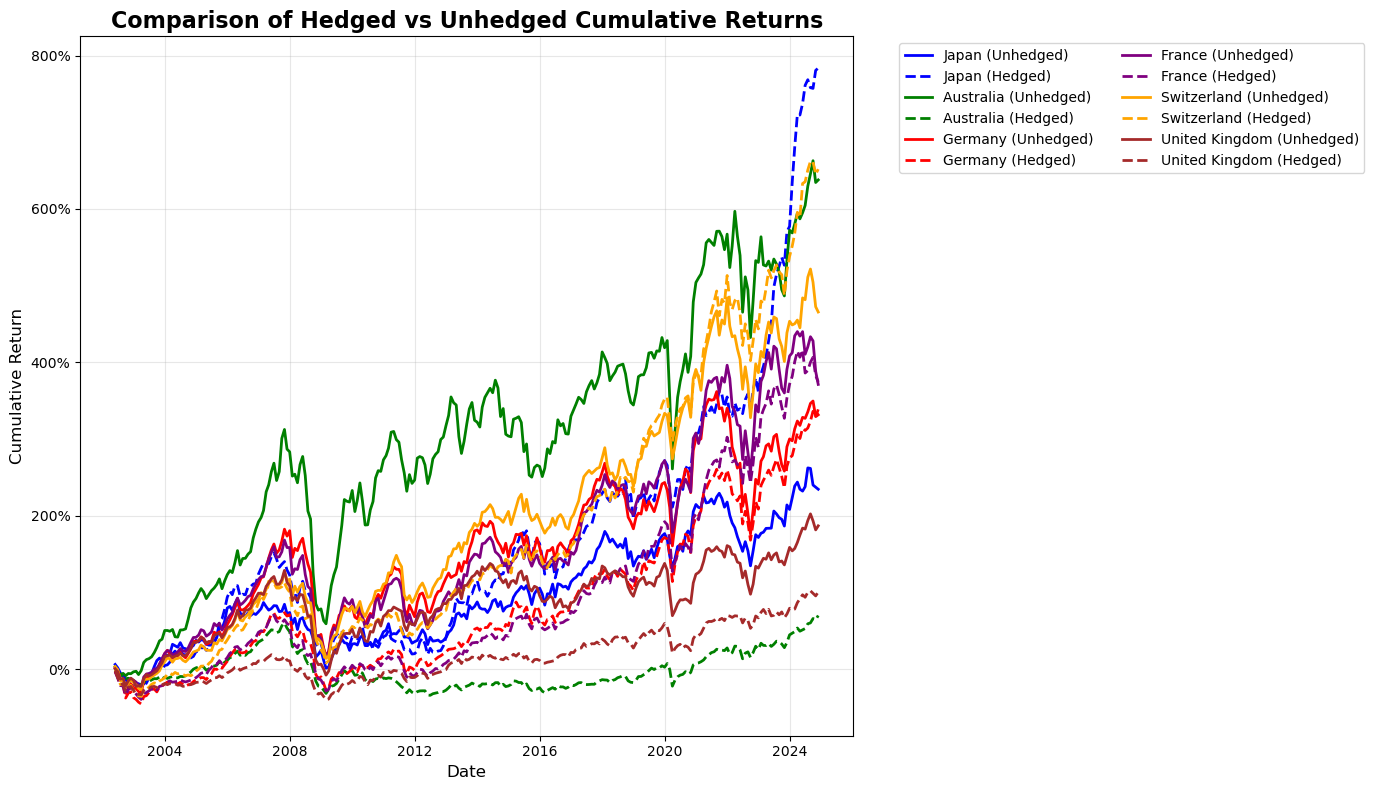

Summary Statistics: Hedged vs Unhedged Returns


Japan (JPN):
  Unhedged - Mean: 6.63%, Std: 15.94%
  Hedged   - Mean: 11.02%, Std: 16.24%
  Std Reduction: -1.9%
  Total Return - Unhedged: 234.6%, Hedged: 783.5%

Australia (AUS):
  Unhedged - Mean: 10.61%, Std: 18.41%
  Hedged   - Mean: 3.32%, Std: 13.74%
  Std Reduction: 25.4%
  Total Return - Unhedged: 637.8%, Hedged: 70.0%

Germany (DEU):
  Unhedged - Mean: 8.59%, Std: 20.27%
  Hedged   - Mean: 8.17%, Std: 17.70%
  Std Reduction: 12.7%
  Total Return - Unhedged: 331.6%, Hedged: 338.7%

France (FRA):
  Unhedged - Mean: 8.67%, Std: 18.87%
  Hedged   - Mean: 8.25%, Std: 16.29%
  Std Reduction: 13.7%
  Total Return - Unhedged: 371.2%, Hedged: 374.4%

Switzerland (CHE):
  Unhedged - Mean: 8.92%, Std: 15.59%
  Hedged   - Mean: 9.87%, Std: 13.41%
  Std Reduction: 14.0%
  Total Return - Unhedged: 465.6%, Hedged: 651.8%

United Kingdom (GBR):
  Unhedged - Mean: 6.02%, Std: 16.28%
  Hedged   - Mean: 3.97%, Std: 13.21%
  Std Reduction: 18.9%
 

In [16]:
# Create a figure with subplots for each country
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Calculate cumulative returns for both hedged and unhedged
# Formula: cumulative return = (1 + r1) * (1 + r2) * ... * (1 + rn) - 1
# We'll use cumulative product of (1 + returns)

# Get common dates between hedged and unhedged returns
common_dates = idx_returns.index.intersection(hedged_returns.index)

# Country names for titles
country_names = {
    "JPN": "Japan",
    "AUS": "Australia", 
    "DEU": "Germany",
    "FRA": "France",
    "CHE": "Switzerland",
    "GBR": "United Kingdom"
}

for i, iso_code in enumerate(idx_returns.columns):
    # Get aligned data
    unhedged = idx_returns[iso_code].loc[common_dates]
    hedged = hedged_returns[iso_code].loc[common_dates]
    
    # Calculate cumulative returns
    cum_unhedged = (1 + unhedged).cumprod() - 1
    cum_hedged = (1 + hedged).cumprod() - 1
    
    # Plot on the appropriate subplot
    ax = axes[i]
    ax.plot(cum_unhedged.index, cum_unhedged.values, 
            label='Unhedged', linewidth=2, color='blue')
    ax.plot(cum_hedged.index, cum_hedged.values, 
            label='Hedged', linewidth=2, color='red', linestyle='--')
    
    # Formatting
    ax.set_title(f'{country_names[iso_code]} ({iso_code})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Hedged vs Unhedged Cumulative Returns by Country', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Create a single plot with all countries
plt.figure(figsize=(14, 8))

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for i, iso_code in enumerate(idx_returns.columns):
    # Get aligned data
    unhedged = idx_returns[iso_code].loc[common_dates]
    hedged = hedged_returns[iso_code].loc[common_dates]
    
    # Calculate cumulative returns
    cum_unhedged = (1 + unhedged).cumprod() - 1
    cum_hedged = (1 + hedged).cumprod() - 1
    
    # Plot
    plt.plot(cum_unhedged.index, cum_unhedged.values, 
            label=f'{country_names[iso_code]} (Unhedged)', 
            linewidth=2, color=colors[i])
    plt.plot(cum_hedged.index, cum_hedged.values, 
            label=f'{country_names[iso_code]} (Hedged)', 
            linewidth=2, color=colors[i], linestyle='--')

plt.title('Comparison of Hedged vs Unhedged Cumulative Returns', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

# Summary statistics comparison
print("Summary Statistics: Hedged vs Unhedged Returns\n")
print("="*70)

for iso_code in idx_returns.columns:
    unhedged = idx_returns[iso_code].loc[common_dates]
    hedged = hedged_returns[iso_code].loc[common_dates]
    
    print(f"\n{country_names[iso_code]} ({iso_code}):")
    print(f"  Unhedged - Mean: {unhedged.mean()*12:.2%}, Std: {unhedged.std()*np.sqrt(12):.2%}")
    print(f"  Hedged   - Mean: {hedged.mean()*12:.2%}, Std: {hedged.std()*np.sqrt(12):.2%}")
    print(f"  Std Reduction: {(1 - hedged.std()/unhedged.std())*100:.1f}%")
    
    # Final cumulative returns
    final_unhedged = (1 + unhedged).prod() - 1
    final_hedged = (1 + hedged).prod() - 1
    print(f"  Total Return - Unhedged: {final_unhedged:.1%}, Hedged: {final_hedged:.1%}")